# Image Reconstruction using CNN

Here, I will investigate if we can use DL to reconstruct MNIST data that has been encoded with coded aperture.   
**Research Question:** Given a coded image, 
(1) can we recover/reconstruct the image, and
(2) can we recover the decoding pattern?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision.transforms as transforms
from torchvision import datasets
import torch
import sklearn
import wandb

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura
from CNN import CNN
import confusion_matrix as cm

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [3]:
# Update plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,10],
})

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
wandb.login()

Using cpu device


wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


True

# Prepare MNIST Data

## Hyperparameters
Here, I will define hyperparameters for both the model and some needed for preprocessing.  

To define the MURA encoding and decoding, we first define a size $p$ for the MURA array and then use the encoder and decoding functions to create the encoder array $A$ and the decoder array $G$

In [5]:
%%time
# define hyperparameters
params = {
  "dataset": "MNIST",
 # "machine": "desktop",
  "model": "CNN",
  "learning_rate": 1e-3,
  "batch_size": 100,
  "epochs": 200,
  "kernel_size":23,
  "image_size": 23
}
wandb.config = params

# Compute MURA encoder and decoder
p = params['image_size'] # size of array (has to be prime)
A = mura.create_binary_aperture_arr(p)
G = mura.create_decoding_arr(A)

CPU times: user 1.38 ms, sys: 58 µs, total: 1.43 ms
Wall time: 1.42 ms


## Transform data
The MNIST data is originally defined as a tuple of (images, labels). We will redefine the tuple to be (encoded image, original image) for this reconstruction task. 
Both the encoded images and original images will be size $p \times p$. 

In [6]:
# Define the size of MNIST image to be equal to the size of A 
#size = params['image_size'] #A.shape[0]

# Load MNIST data from PyTorch and
    # (1) Convert to tensor
    # (2) Resize from 28x28 to pxp 
    # (3) Normalize entries between [0,1]
train_data = datasets.MNIST(
    root = '../data/',
    train = True,                         
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(params['image_size']),
                    transforms.Normalize(0, 1)
                ]), 
    download = False,            
)

test_data = datasets.MNIST(
    root = '../data/', 
    train = False, 
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(params['image_size']),
                    transforms.Normalize(0, 1)
                ]) 
)

In [11]:
%% time
# Save encoded data 
filename_train = "../data/MNIST_mura_training"
filename_test = "../data/MNIST_mura_test"
#torch.save(mura_train_data, filename_train)
#torch.save(mura_test_data, filename_test)

# Load encoded data
mura_train_data = torch.load(filename_train)
mura_test_data = torch.load(filename_test)

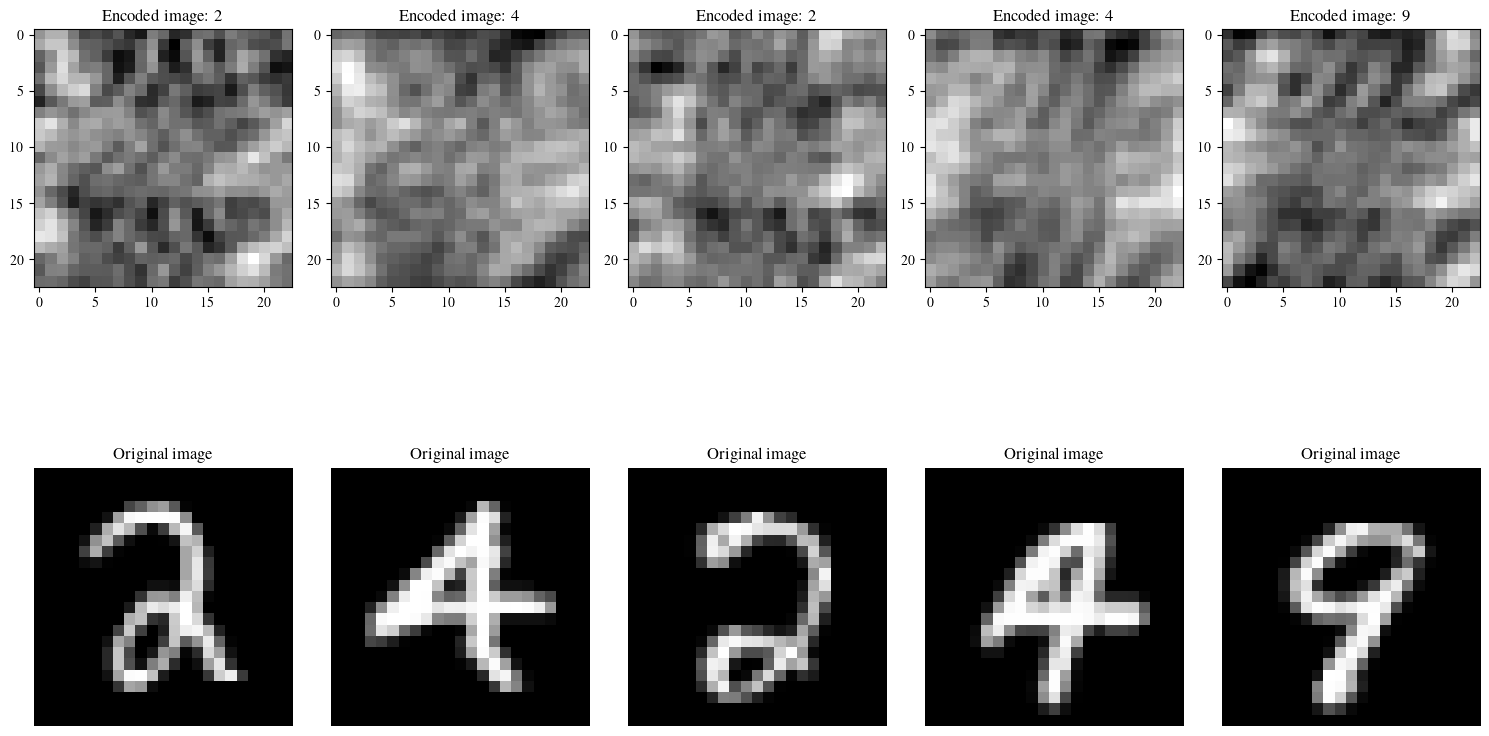

In [13]:
# Printing 25 random images from the training dataset
random_samples = np.random.randint(1, len(mura_train_data), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    plt.imshow(mura_train_data[idx][0][0].numpy(), cmap='gray')
    #plt.colorbar()
    plt.title(f'Encoded image: {mura_train_data[idx][2]}')
    plt.subplot(2, 5, count + 6)
    plt.imshow(mura_train_data[idx][1][0].numpy(), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    
    count += 1
plt.tight_layout()
plt.show()

## Define data loaders with new data

In [14]:
loaders = {
    'train' : torch.utils.data.DataLoader(mura_train_data, 
                                          batch_size=params['batch_size'], 
                                          shuffle=True, 
                                          num_workers=0),
    
    'test'  : torch.utils.data.DataLoader(mura_test_data, 
                                          batch_size=params['batch_size'], 
                                          shuffle=False, 
                                          num_workers=0),
}

# Define Model

In [15]:
class CNN(torch.nn.Module):
    '''
    Define a model with only one convolutional layer layer and sigmoid activation function
    '''
    def __init__(self, params):
        super().__init__()  
        self.img_size = params['image_size']
        self.kernel_size = params['kernel_size']
        self.conv = torch.nn.Conv2d(1,1,kernel_size=self.kernel_size, padding=(self.kernel_size-1)//2)
        
    def forward(self, x):
        output = torch.sigmoid(self.conv(x))
        return output

In [16]:
# Instantiate model 
model = CNN(params)#.to(device)
criterion = torch.nn.MSELoss()#.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = params['learning_rate']) 
PATH = f'../models/CNN_mnist_{params["kernel_size"]}kernel_{params["epochs"]}epochs.pth'

# Training

Initial weights Shape: torch.Size([1, 1, 23, 23])


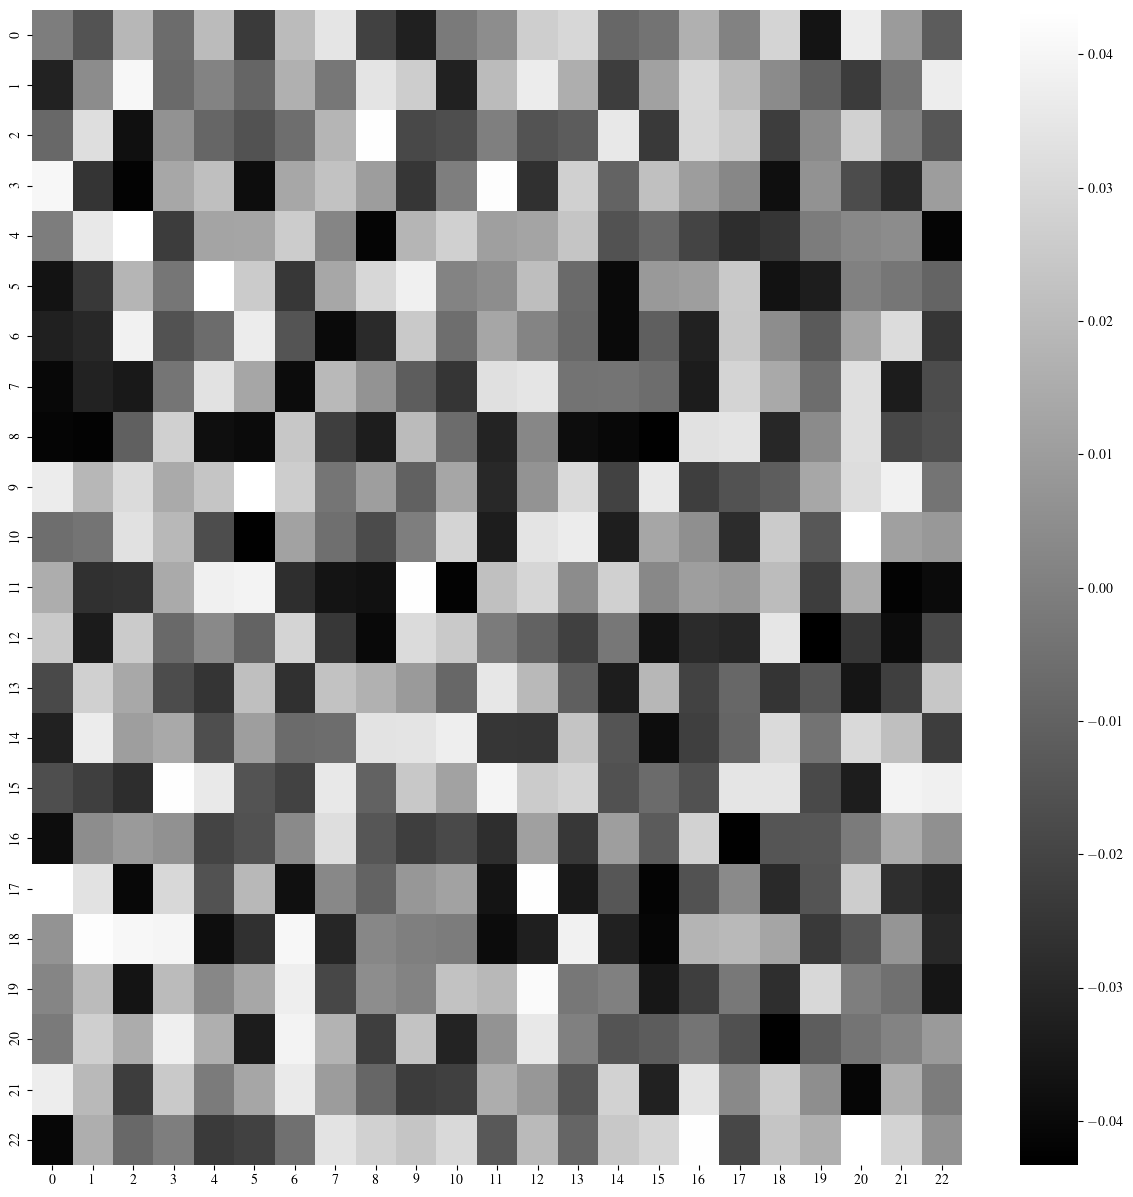

Target weights shape: (23, 23)


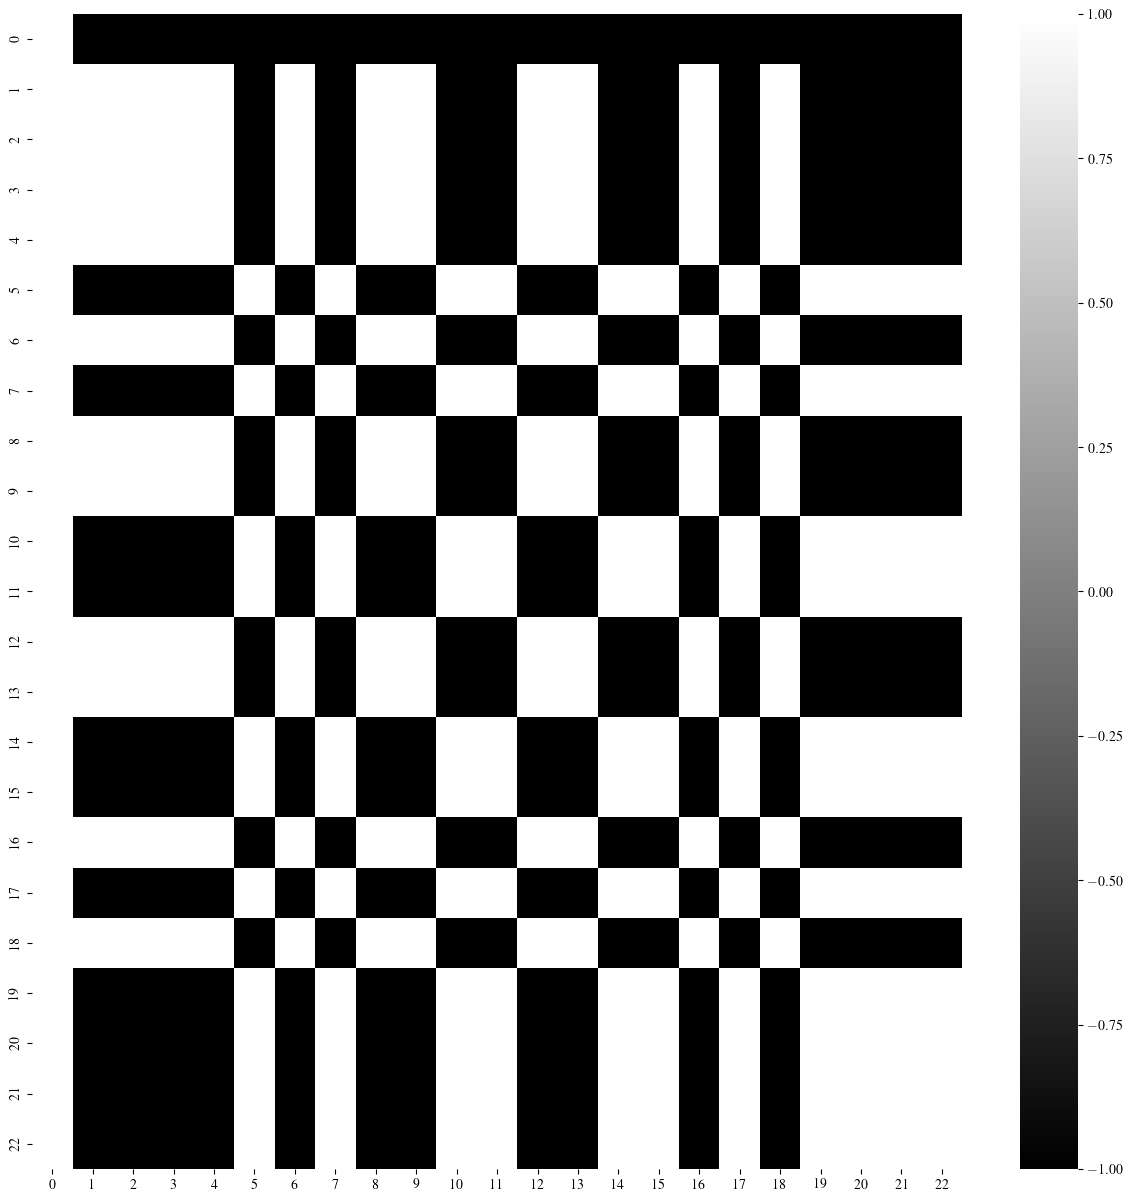

In [17]:
# ----------- Plot initial weights and target weights---- 
# From Jacky's SAR stuff
# Define initial weights from the CNN model
init_weights = list(model.parameters())
init_weight_map = init_weights[0].detach()
print('Initial weights Shape: {}'.format(init_weights[0].shape))

# Plot initial weights
plt.figure(figsize=(15,15))
heat = sns.heatmap(np.squeeze(init_weight_map.cpu().numpy()), cmap='gray')
figure = heat.get_figure()
#figure.savefig(folder_name+'/metrics/heat_init.png',bbox='tight',dpi=400)
#plt.close()
plt.show()

# Define and plot target weights
target_weights = G
print('Target weights shape: {}'.format(target_weights.shape))
plt.figure(figsize=(15,15))
heat = sns.heatmap(target_weights, cmap='gray')
figure = heat.get_figure()
#figure.savefig(folder_name+'/metrics/heat_target.png',bbox='tight',dpi=400)
#plt.close()
plt.show()

In [23]:
%%time
# TODO: Need to fix because now data is tuple of 3, not 2

# Initialize project in Weights and Biases
wandb.init(config=wandb.config, project="coded-aperture-MNIST", group="CNN", name=f"CNN-{params['kernel_size']}kernel-{params['epochs']}epochs")

# Store values for later 
train_loss = []
frob_per_epoch = []
#frob_per_epoch_matrix = []

#Dictionary that will store different images and outputs for various epochs (not sure if needed)
outputs = {}

# Training loop starts
for epoch in range(params['epochs']):
    
    # Initialize variable to store loss
    running_loss = 0
    
    # Iterate over training set
    for i, data in enumerate(loaders['train']):
        # get the inputs; data is a list of [images, labels, digit]
        # Reshape images into 1-d vector
        inputs, targets, digits = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Generate output
        out = model(inputs)
        
        # Calculate loss
        loss = criterion(out, targets)
        
        # Backprop and update weights
        loss.backward()
        optimizer.step()
        
        # Increment loss
        running_loss += loss.item()
        
    # Average loss over entire batch
    running_loss/= params['batch_size']
    train_loss.append(running_loss)
    
    print(f"Epoch {epoch +1} | Loss: {running_loss:.3f}")
    wandb.log({"epoch": epoch, "loss": running_loss})
    
    # Storing images, reconstructed outputs, and labels
    outputs[epoch+1] = {'img': inputs, 'out': out, 'targets': targets, 'digits': digits}
    
#     # Save weights every 10 epochs
    if epoch % 10 == 9:
        epoch_save_model = path+'models/CNN/model_epoch_'+str(epoch)+f'_{params["kernel_size"]}kernel.pth'
        torch.save(model.state_dict(),epoch_save_model)
        weight_epoch_list = list(model.parameters())
        weight_epoch = np.squeeze(weight_epoch_list[0].detach().cpu().numpy())
        plt.figure(figsize=(15,15))
        heat = sns.heatmap(weight_epoch)
        figure = heat.get_figure()
        figure.savefig(path+'/metrics/CNN/heat_epoch_'+str(epoch)+f'{params["kernel_size"]}kernel.png',dpi=400)
        plt.close()
    
    # Calculate Frobenius norm between weights and decoder every epoch
    weights = list(model.parameters())
    weight_map = np.squeeze(weights[0].detach().cpu().numpy())
    diff_block = G - weight_map
    frob_per_epoch.append(np.linalg.norm(np.abs(diff_block),ord='fro'))

#torch.save(model.state_dict(), PATH)
# End WandB run
wandb.finish()

Epoch 1 | Loss: 0.209
Epoch 2 | Loss: 0.203
Epoch 3 | Loss: 0.197
Epoch 4 | Loss: 0.193
Epoch 5 | Loss: 0.190
Epoch 6 | Loss: 0.188
Epoch 7 | Loss: 0.186
Epoch 8 | Loss: 0.184
Epoch 9 | Loss: 0.183
Epoch 10 | Loss: 0.182


<timed exec>:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6


Epoch 11 | Loss: 0.181
Epoch 12 | Loss: 0.181
Epoch 13 | Loss: 0.180
Epoch 14 | Loss: 0.180
Epoch 15 | Loss: 0.179
Epoch 16 | Loss: 0.179
Epoch 17 | Loss: 0.178
Epoch 18 | Loss: 0.178
Epoch 19 | Loss: 0.178
Epoch 20 | Loss: 0.178


<timed exec>:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6


Epoch 21 | Loss: 0.177
Epoch 22 | Loss: 0.177
Epoch 23 | Loss: 0.177
Epoch 24 | Loss: 0.177
Epoch 25 | Loss: 0.177
Epoch 26 | Loss: 0.177
Epoch 27 | Loss: 0.177
Epoch 28 | Loss: 0.177
Epoch 29 | Loss: 0.177
Epoch 30 | Loss: 0.176


<timed exec>:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6


Epoch 31 | Loss: 0.176
Epoch 32 | Loss: 0.176
Epoch 33 | Loss: 0.176
Epoch 34 | Loss: 0.176
Epoch 35 | Loss: 0.176
Epoch 36 | Loss: 0.176
Epoch 37 | Loss: 0.176
Epoch 38 | Loss: 0.176
Epoch 39 | Loss: 0.176
Epoch 40 | Loss: 0.176
Epoch 41 | Loss: 0.176
Epoch 42 | Loss: 0.176
Epoch 43 | Loss: 0.176
Epoch 44 | Loss: 0.176
Epoch 45 | Loss: 0.176
Epoch 46 | Loss: 0.176
Epoch 47 | Loss: 0.175
Epoch 48 | Loss: 0.175
Epoch 49 | Loss: 0.175
Epoch 50 | Loss: 0.175


<timed exec>:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6


Epoch 51 | Loss: 0.175
Epoch 52 | Loss: 0.175
Epoch 53 | Loss: 0.175
Epoch 54 | Loss: 0.175
Epoch 55 | Loss: 0.175
Epoch 56 | Loss: 0.175
Epoch 57 | Loss: 0.175
Epoch 58 | Loss: 0.175
Epoch 59 | Loss: 0.175
Epoch 60 | Loss: 0.175


<timed exec>:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6


Epoch 61 | Loss: 0.175
Epoch 62 | Loss: 0.175
Epoch 63 | Loss: 0.175
Epoch 64 | Loss: 0.175
Epoch 65 | Loss: 0.175
Epoch 66 | Loss: 0.175
Epoch 67 | Loss: 0.175
Epoch 68 | Loss: 0.175
Epoch 69 | Loss: 0.175
Epoch 70 | Loss: 0.175


<timed exec>:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6


Epoch 71 | Loss: 0.175
Epoch 72 | Loss: 0.175
Epoch 73 | Loss: 0.175
Epoch 74 | Loss: 0.175
Epoch 75 | Loss: 0.175
Epoch 76 | Loss: 0.175
Epoch 77 | Loss: 0.175
Epoch 78 | Loss: 0.175
Epoch 79 | Loss: 0.175
Epoch 80 | Loss: 0.175


<timed exec>:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6


Epoch 81 | Loss: 0.175
Epoch 82 | Loss: 0.175
Epoch 83 | Loss: 0.175
Epoch 84 | Loss: 0.175
Epoch 85 | Loss: 0.175
Epoch 86 | Loss: 0.175
Epoch 87 | Loss: 0.175
Epoch 88 | Loss: 0.175
Epoch 89 | Loss: 0.175
Epoch 90 | Loss: 0.175
Epoch 91 | Loss: 0.175
Epoch 92 | Loss: 0.175
Epoch 93 | Loss: 0.175
Epoch 94 | Loss: 0.175
Epoch 95 | Loss: 0.175
Epoch 96 | Loss: 0.175
Epoch 97 | Loss: 0.175
Epoch 98 | Loss: 0.175
Epoch 99 | Loss: 0.175
Epoch 100 | Loss: 0.175
Epoch 101 | Loss: 0.175
Epoch 102 | Loss: 0.175
Epoch 103 | Loss: 0.175
Epoch 104 | Loss: 0.175
Epoch 105 | Loss: 0.175
Epoch 106 | Loss: 0.175
Epoch 107 | Loss: 0.175
Epoch 108 | Loss: 0.175
Epoch 109 | Loss: 0.175
Epoch 110 | Loss: 0.175
Epoch 111 | Loss: 0.175
Epoch 112 | Loss: 0.175
Epoch 113 | Loss: 0.175
Epoch 114 | Loss: 0.175
Epoch 115 | Loss: 0.175
Epoch 116 | Loss: 0.174
Epoch 117 | Loss: 0.175
Epoch 118 | Loss: 0.175
Epoch 119 | Loss: 0.175
Epoch 120 | Loss: 0.174
Epoch 121 | Loss: 0.175
Epoch 122 | Loss: 0.174
Epoch 123 |

<timed exec>:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6


Epoch 141 | Loss: 0.174
Epoch 142 | Loss: 0.174
Epoch 143 | Loss: 0.174
Epoch 144 | Loss: 0.174
Epoch 145 | Loss: 0.174
Epoch 146 | Loss: 0.174
Epoch 147 | Loss: 0.174
Epoch 148 | Loss: 0.174
Epoch 149 | Loss: 0.174
Epoch 150 | Loss: 0.174


<timed exec>:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6


Epoch 151 | Loss: 0.174
Epoch 152 | Loss: 0.174
Epoch 153 | Loss: 0.174
Epoch 154 | Loss: 0.174
Epoch 155 | Loss: 0.174
Epoch 156 | Loss: 0.174
Epoch 157 | Loss: 0.174
Epoch 158 | Loss: 0.174
Epoch 159 | Loss: 0.174
Epoch 160 | Loss: 0.174


<timed exec>:61: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error in 3.6


Epoch 161 | Loss: 0.174
Epoch 162 | Loss: 0.174
Epoch 163 | Loss: 0.174
Epoch 164 | Loss: 0.174
Epoch 165 | Loss: 0.174
Epoch 166 | Loss: 0.174
Epoch 167 | Loss: 0.174
Epoch 168 | Loss: 0.174
Epoch 169 | Loss: 0.174
Epoch 170 | Loss: 0.174
Epoch 171 | Loss: 0.174
Epoch 172 | Loss: 0.174
Epoch 173 | Loss: 0.174
Epoch 174 | Loss: 0.174
Epoch 175 | Loss: 0.174
Epoch 176 | Loss: 0.174
Epoch 177 | Loss: 0.174
Epoch 178 | Loss: 0.174
Epoch 179 | Loss: 0.174
Epoch 180 | Loss: 0.174
Epoch 181 | Loss: 0.174
Epoch 182 | Loss: 0.174
Epoch 183 | Loss: 0.174
Epoch 184 | Loss: 0.174
Epoch 185 | Loss: 0.174
Epoch 186 | Loss: 0.174
Epoch 187 | Loss: 0.174
Epoch 188 | Loss: 0.174
Epoch 189 | Loss: 0.174
Epoch 190 | Loss: 0.174
Epoch 191 | Loss: 0.174
Epoch 192 | Loss: 0.174
Epoch 193 | Loss: 0.174
Epoch 194 | Loss: 0.174
Epoch 195 | Loss: 0.174
Epoch 196 | Loss: 0.174
Epoch 197 | Loss: 0.174
Epoch 198 | Loss: 0.174
Epoch 199 | Loss: 0.174
Epoch 200 | Loss: 0.174


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,199
loss,0.17435


CPU times: user 2h 30min 47s, sys: 2min 15s, total: 2h 33min 3s
Wall time: 2h 50min 44s


In [26]:
#----------------------------- Save The Losses -----------------------------
import pickle
with open(path+'metrics/CNN/train_loss.pkl','wb') as fp:
    pickle.dump(train_loss, fp)
with open(path+'metrics/CNN/weight_norm.pkl','wb') as fp:
    pickle.dump(frob_per_epoch, fp)
# with open(path+'metrics/matrix_norm.pkl','wb') as fp:
#     pickle.dump(frob_per_epoch_matrix, fp)


# Evaluation

In [19]:
# Load model if one is not loaded already
model.load_state_dict(torch.load(PATH))
# Print out the keys save in the state dictionary
for key in list(model.state_dict().keys()):
    print(key)

conv.weight
conv.bias


In [21]:
# Load Frobenius norm and training loss
frob_per_epoch = np.load(path+'metrics/CNN/weight_norm.pkl', allow_pickle=True)
train_loss = np.load(path+'metrics/CNN/train_loss.pkl', allow_pickle=True)

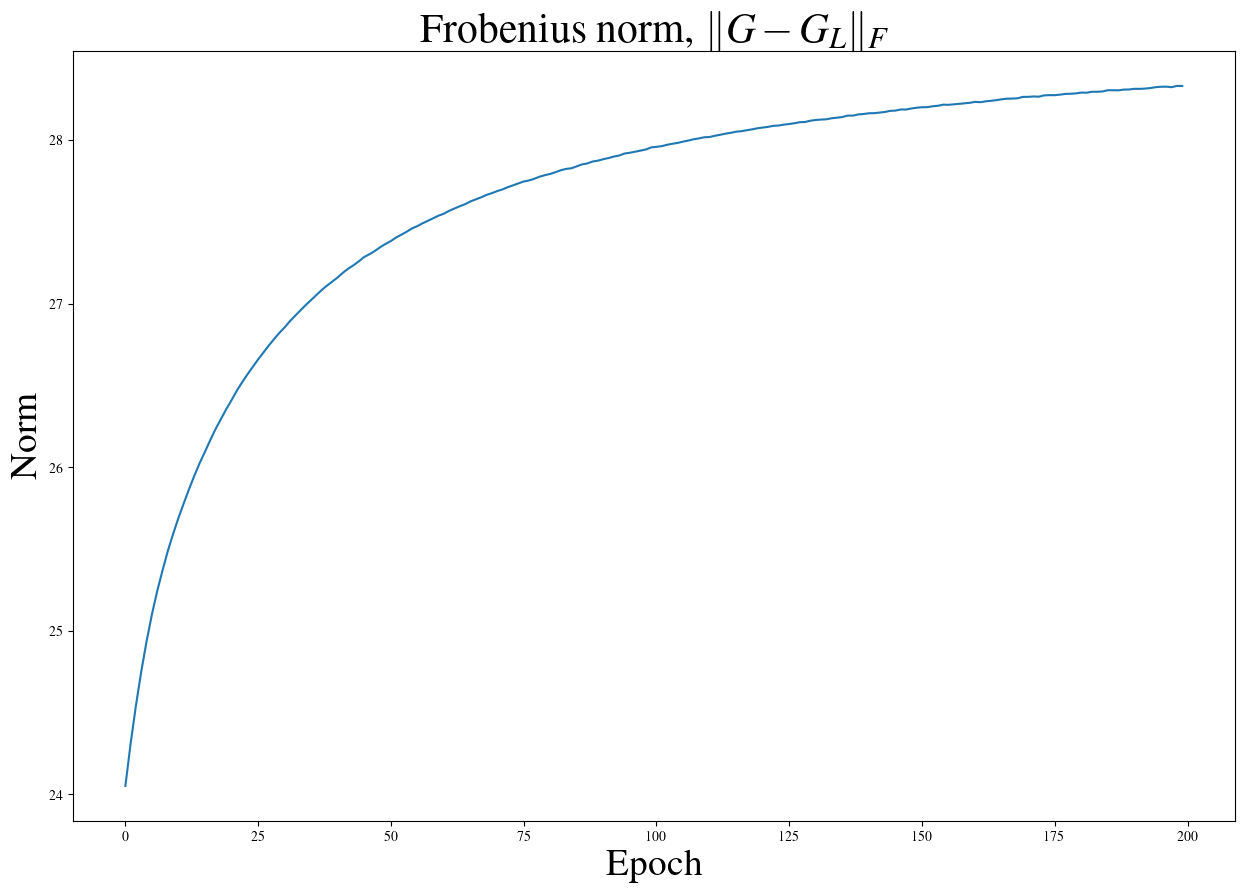

In [22]:
# # Plot weights
# plt.imshow(torch.squeeze(model.state_dict()['conv.weight']), cmap='gray')
# plt.colorbar()
# plt.show()

# plot frob per epoch
plt.plot(np.arange(params['epochs']), frob_per_epoch)
plt.title("Frobenius norm, $\|G-G_L\|_F$", fontsize=30)
plt.xlabel("Epoch", fontsize=27)
plt.ylabel("Norm", fontsize=27)
#plt.savefig(path+'figs/frob_per_epoch_CNN.png')
plt.show()

## Plot training loss

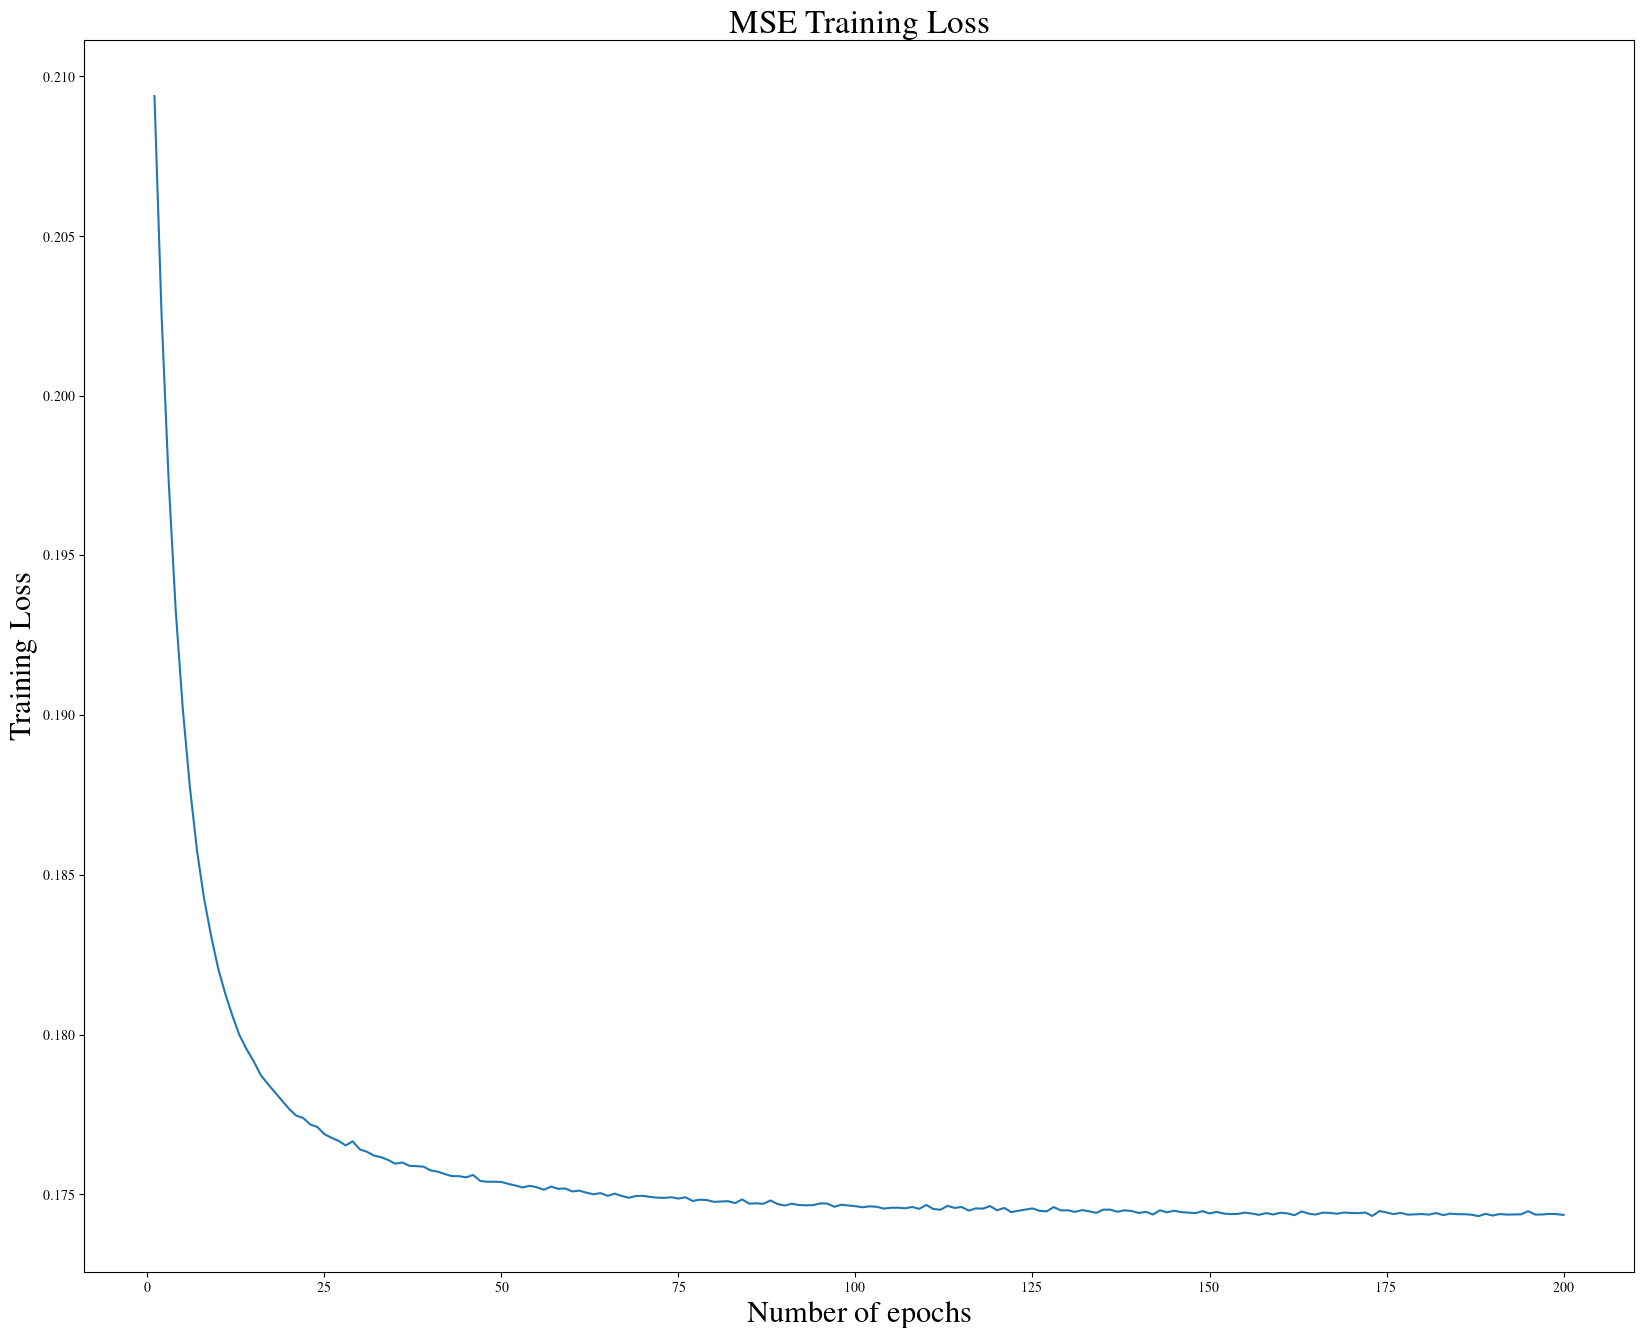

In [77]:
# Plotting the training loss
#plt.plot(range(1, params['epochs']+1), train_loss)
fontsize = 24
plt.plot(range(1,params['epochs']+1), train_loss)
plt.xlabel("Number of epochs", fontsize = fontsize-2)
plt.ylabel("Training Loss", fontsize = fontsize-2)
plt.title("MSE Training Loss", fontsize=fontsize)
#plt.savefig(f'../figs/training_loss_{params["kernel_size"]}kernel_{params["epochs"]}epochs_1conv.png')
plt.show()

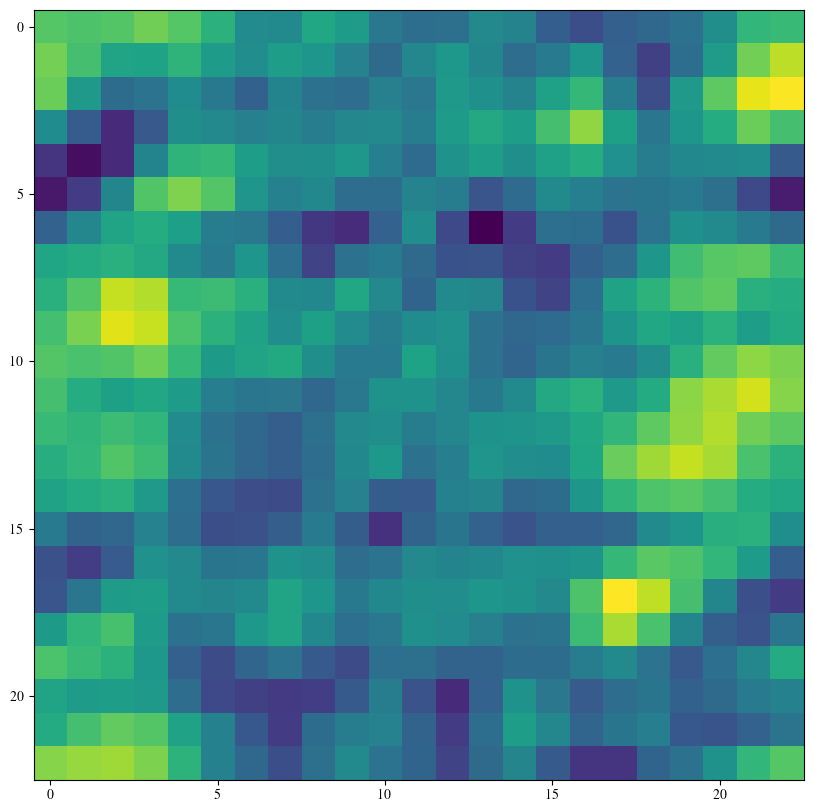

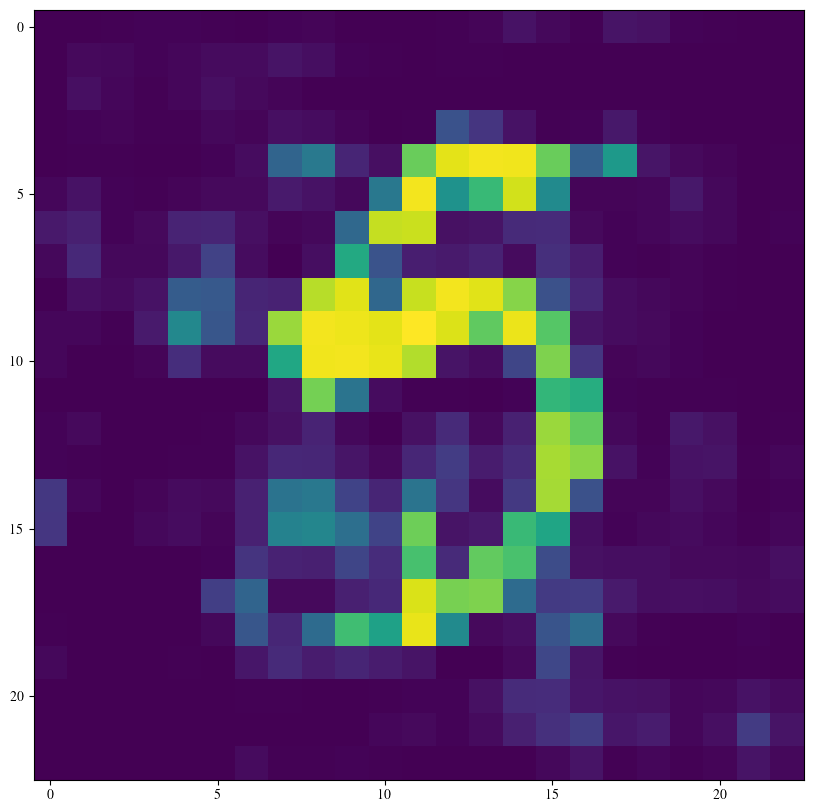

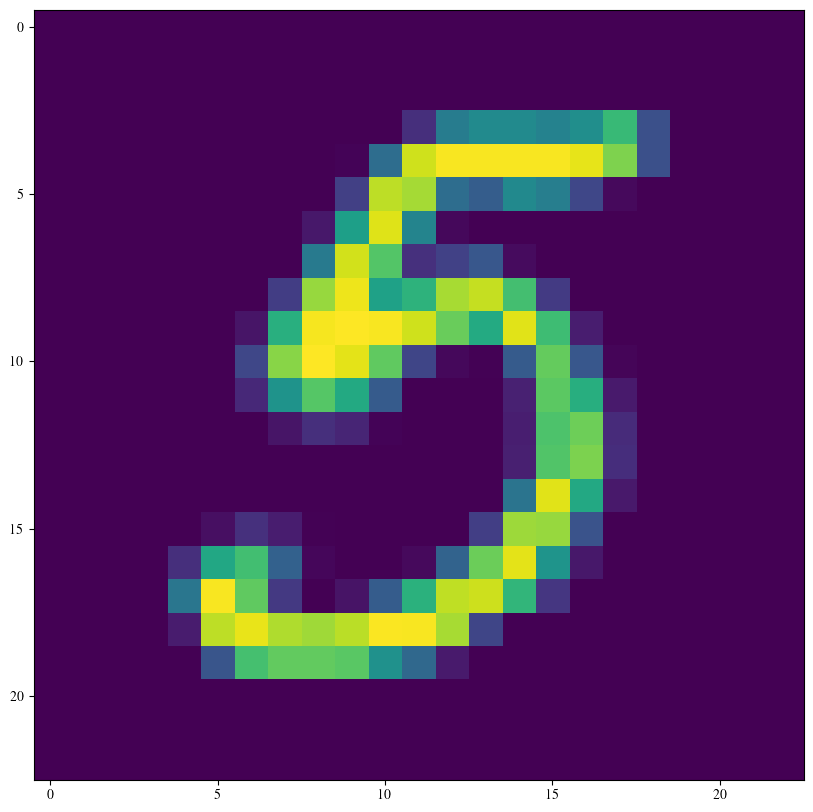

In [38]:
# Plot progression of model throughout the epochs
idx = 150
plt.imshow(torch.reshape(outputs[idx]['img'][10], (model.img_size, model.img_size))); plt.show()
plt.imshow(torch.reshape(outputs[idx]['out'].detach()[10], (model.img_size, model.img_size))); plt.show()
plt.imshow(torch.reshape(outputs[idx]['targets'][10], (model.img_size, model.img_size))); plt.show()

# Code for test set evaluation that I need to modify

In [44]:
# Initialize variables
images_all = []
predicted_all = []
labels_all = []
digit_labels_all = []
mse_all = []
test_outputs = {}

with torch.no_grad():
    for data in loaders['test']:
        # get images and labels from test set
        img_batch, label_batch, digit_batch = data
        # # Reshaping into 1d vector
        # img_batch = img_batch.reshape(-1, model.img_size * model.img_size)
        # label_batch = label_batch.reshape(params['batch_size'],model.img_size *model.img_size)
        
        # calculate outputs by running images through the network (done in batches)
        pred_batch = model(img_batch)
        
        # Calculate MSE for each pair of label,prediction images
        for image, label, prediction, digit in zip(img_batch, label_batch, pred_batch, digit_batch):
            one_mse = sklearn.metrics.mean_squared_error(torch.squeeze(label), torch.squeeze(prediction))
            # Store values in lists
            mse_all.append(one_mse)
            images_all.append(image)#.reshape(-1, model.img_size, model.img_size))
            labels_all.append(label)#.reshape(-1, model.img_size, model.img_size))
            predicted_all.append(prediction)#.reshape(-1, model.img_size, model.img_size))
            digit_labels_all.append(digit.numpy())
            
            
            
        # # Storing information in dictionary
        # test_outputs['img']       = img_batch.reshape(-1, model.img_size, model.img_size)
        # test_outputs['pred']      = pred_batch.reshape(-1, model.img_size, model.img_size)
        # test_outputs['label']     = label_batch.reshape(-1, model.img_size, model.img_size)
    # Storing information in dictionary
    test_outputs['img']       = images_all
    test_outputs['label']     = labels_all
    test_outputs['pred']      = predicted_all
    test_outputs['digit']     = digit_labels_all
    test_outputs['mse_score'] = mse_all

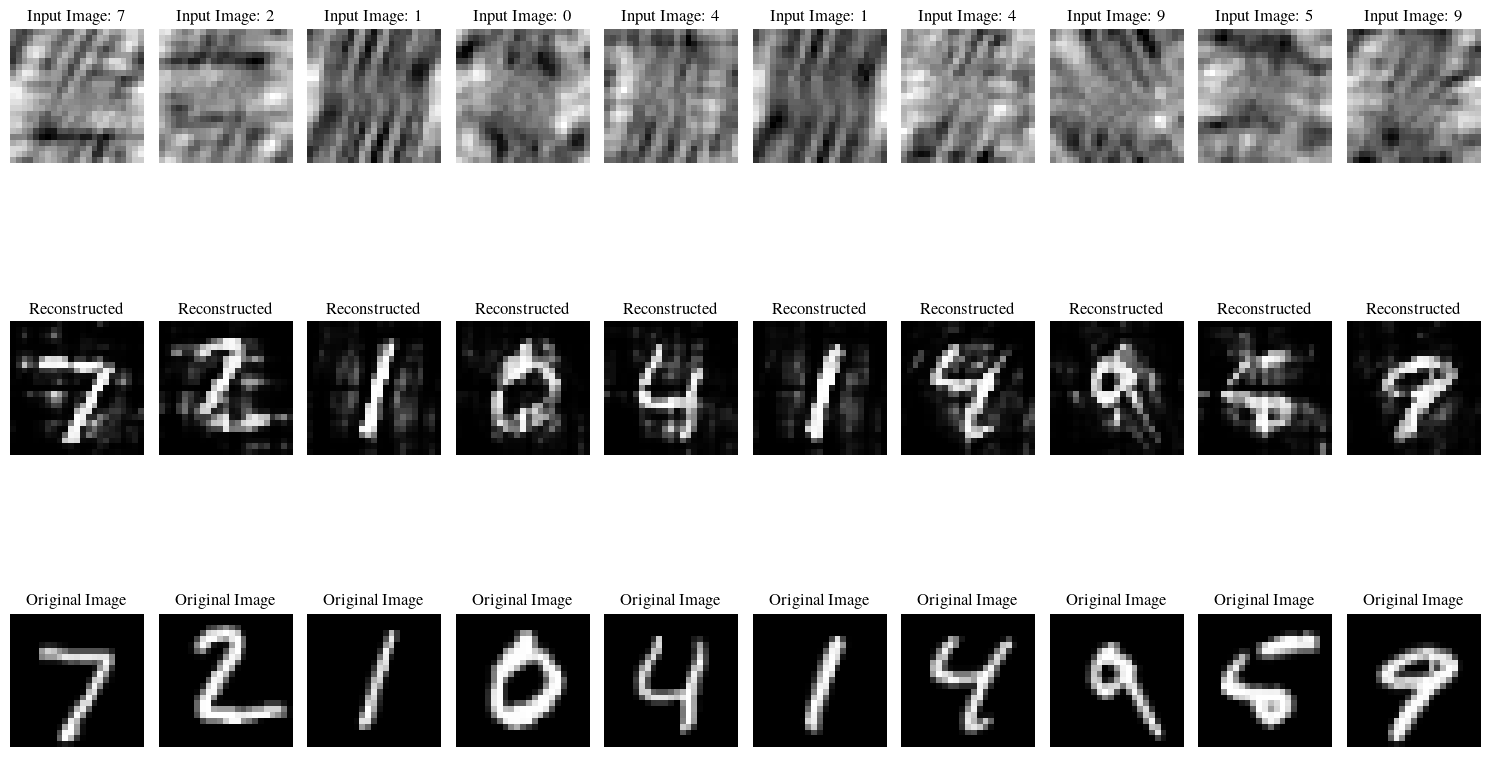

In [45]:
# Plotting reconstructed images
# Initializing subplot counter
counter = 1

# Plotting original images

# Plotting first 10 images
for idx in range(10):
    val = test_outputs['img']
    plt.subplot(3, 10, counter)
    plt.imshow(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    plt.title(f"Input Image: {test_outputs['digit'][idx]}")
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1

# Plotting reconstructions
val = test_outputs['pred']#.numpy()
  
# Plotting first 10 images of the batch
for idx in range(10):
    plt.subplot(3, 10, counter)
    plt.title("Reconstructed")
    plt.imshow(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
    
# Plotting label images

# Plotting first 10 images
for idx in range(10):
    val = test_outputs['label']
    plt.subplot(3, 10, counter)
    plt.imshow(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
    

plt.tight_layout()
plt.show()

# Pandas DF with Images, Labels, Predictions, Digits, and MSE Scores

In [55]:
df = pd.DataFrame.from_dict(test_outputs)
df.digit = df.digit.astype('str')
df.head()

,img,label,pred,digit,mse_score
0,"[[[tensor(0.4563), tensor(0.3096), tensor(0.23...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[[tensor(0.0006), tensor(0.0050), tensor(0.00...",7,0.023381
1,"[[[tensor(0.8751), tensor(0.9118), tensor(0.71...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[[tensor(5.8721e-05), tensor(0.0024), tensor(...",2,0.028765
2,"[[[tensor(0.2268), tensor(0.4273), tensor(0.47...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[[tensor(7.9706e-05), tensor(0.0011), tensor(...",1,0.015717
3,"[[[tensor(0.8511), tensor(0.6584), tensor(0.46...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[[tensor(0.0003), tensor(0.0150), tensor(0.02...",0,0.030416
4,"[[[tensor(0.3855), tensor(0.4044), tensor(0.39...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[[tensor(0.0031), tensor(0.0066), tensor(0.00...",4,0.014442


In [47]:
df.mse_score.describe()

count    10000.000000
mean         0.028930
std          0.015877
min          0.006059
25%          0.018167
50%          0.024636
75%          0.035165
max          0.130144
Name: mse_score, dtype: float64

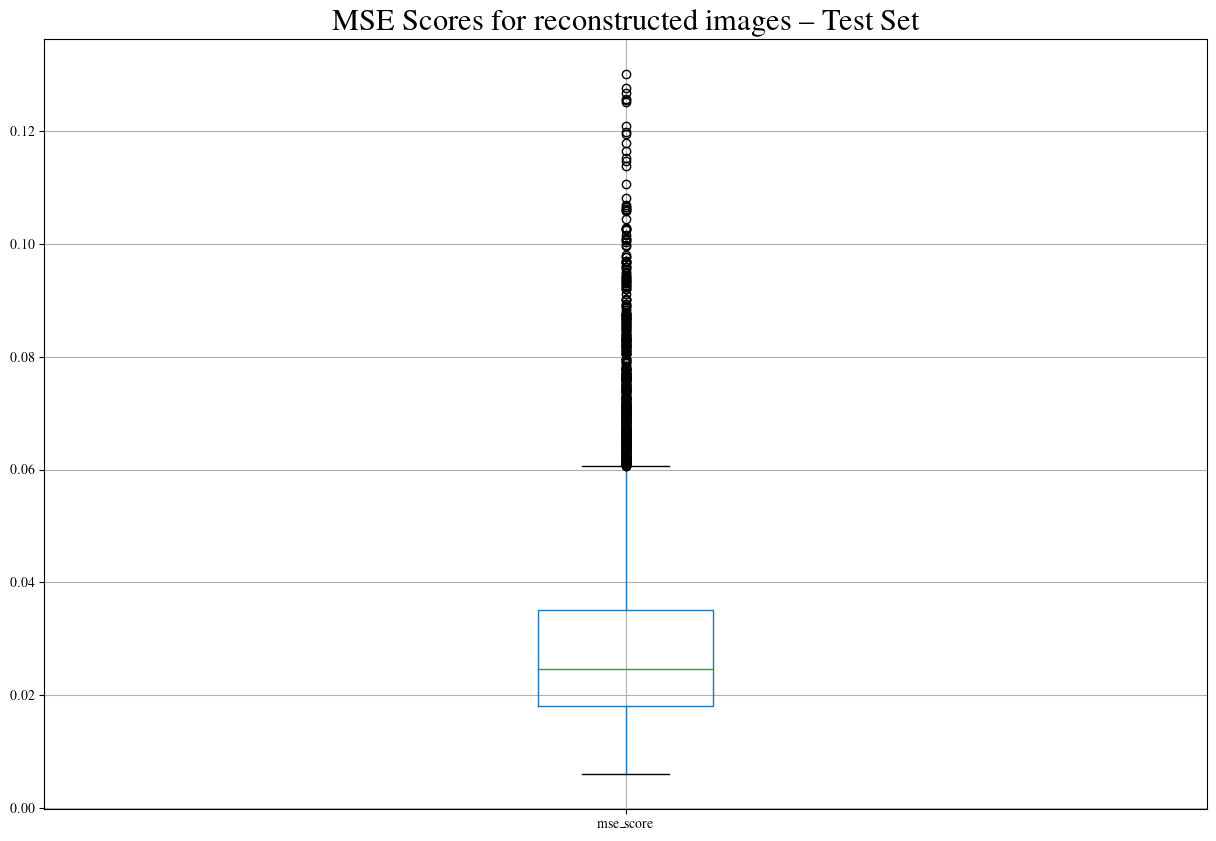

In [48]:
df.boxplot(column='mse_score')
plt.title("MSE Scores for reconstructed images -- Test Set", fontsize=22)
#plt.savefig('../figs/mse_test_recon.png')
plt.show()

<AxesSubplot:title={'center':'mse_score'}, xlabel='digit'>

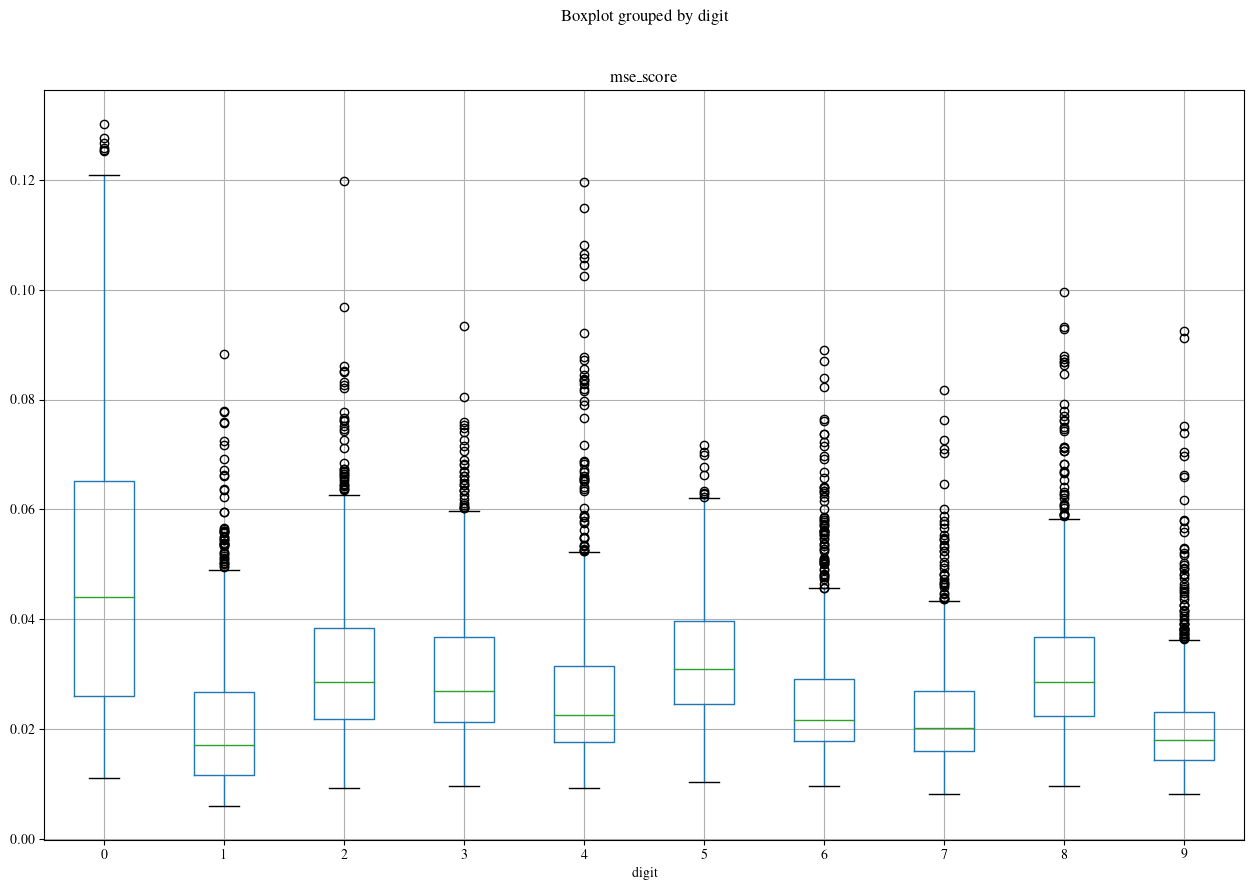

In [54]:
df.boxplot(column='mse_score', by='digit')

## Bad preds

In [49]:
# get all the entries that are above the mean MSE
# higher MSE means worse reconstructions, so we want to look at those
bad_preds = df[df.mse_score > df.mse_score.describe()[1]].copy()

In [50]:
# See which digits have MSE above the mean (i.e. which digits did the model do worse at reconstructing?)
bad_preds.digit.astype('int64').value_counts(normalize=True)

0    0.184372
5    0.140487
2    0.133797
8    0.124967
3    0.119615
4    0.080278
1    0.065828
6    0.064490
7    0.054054
9    0.032111
Name: digit, dtype: float64

## Plotting quantiles

In [51]:
# Get top 25% entries
# count    10000.000000
# mean         0.061068
# std          0.039483
# min          0.002345
# 25%          0.033087
# 50%          0.053249
# 75%          0.079502
# max          0.330395
top_25per = df[df.mse_score < df.mse_score.describe()[4]]#.sample(n=5).index
bottom_25per = df[df.mse_score > df.mse_score.describe()[6]]

In [52]:
df[df.mse_score > 0.29]

,img,label,pred,digit,mse_score


In [53]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [20,16],
})

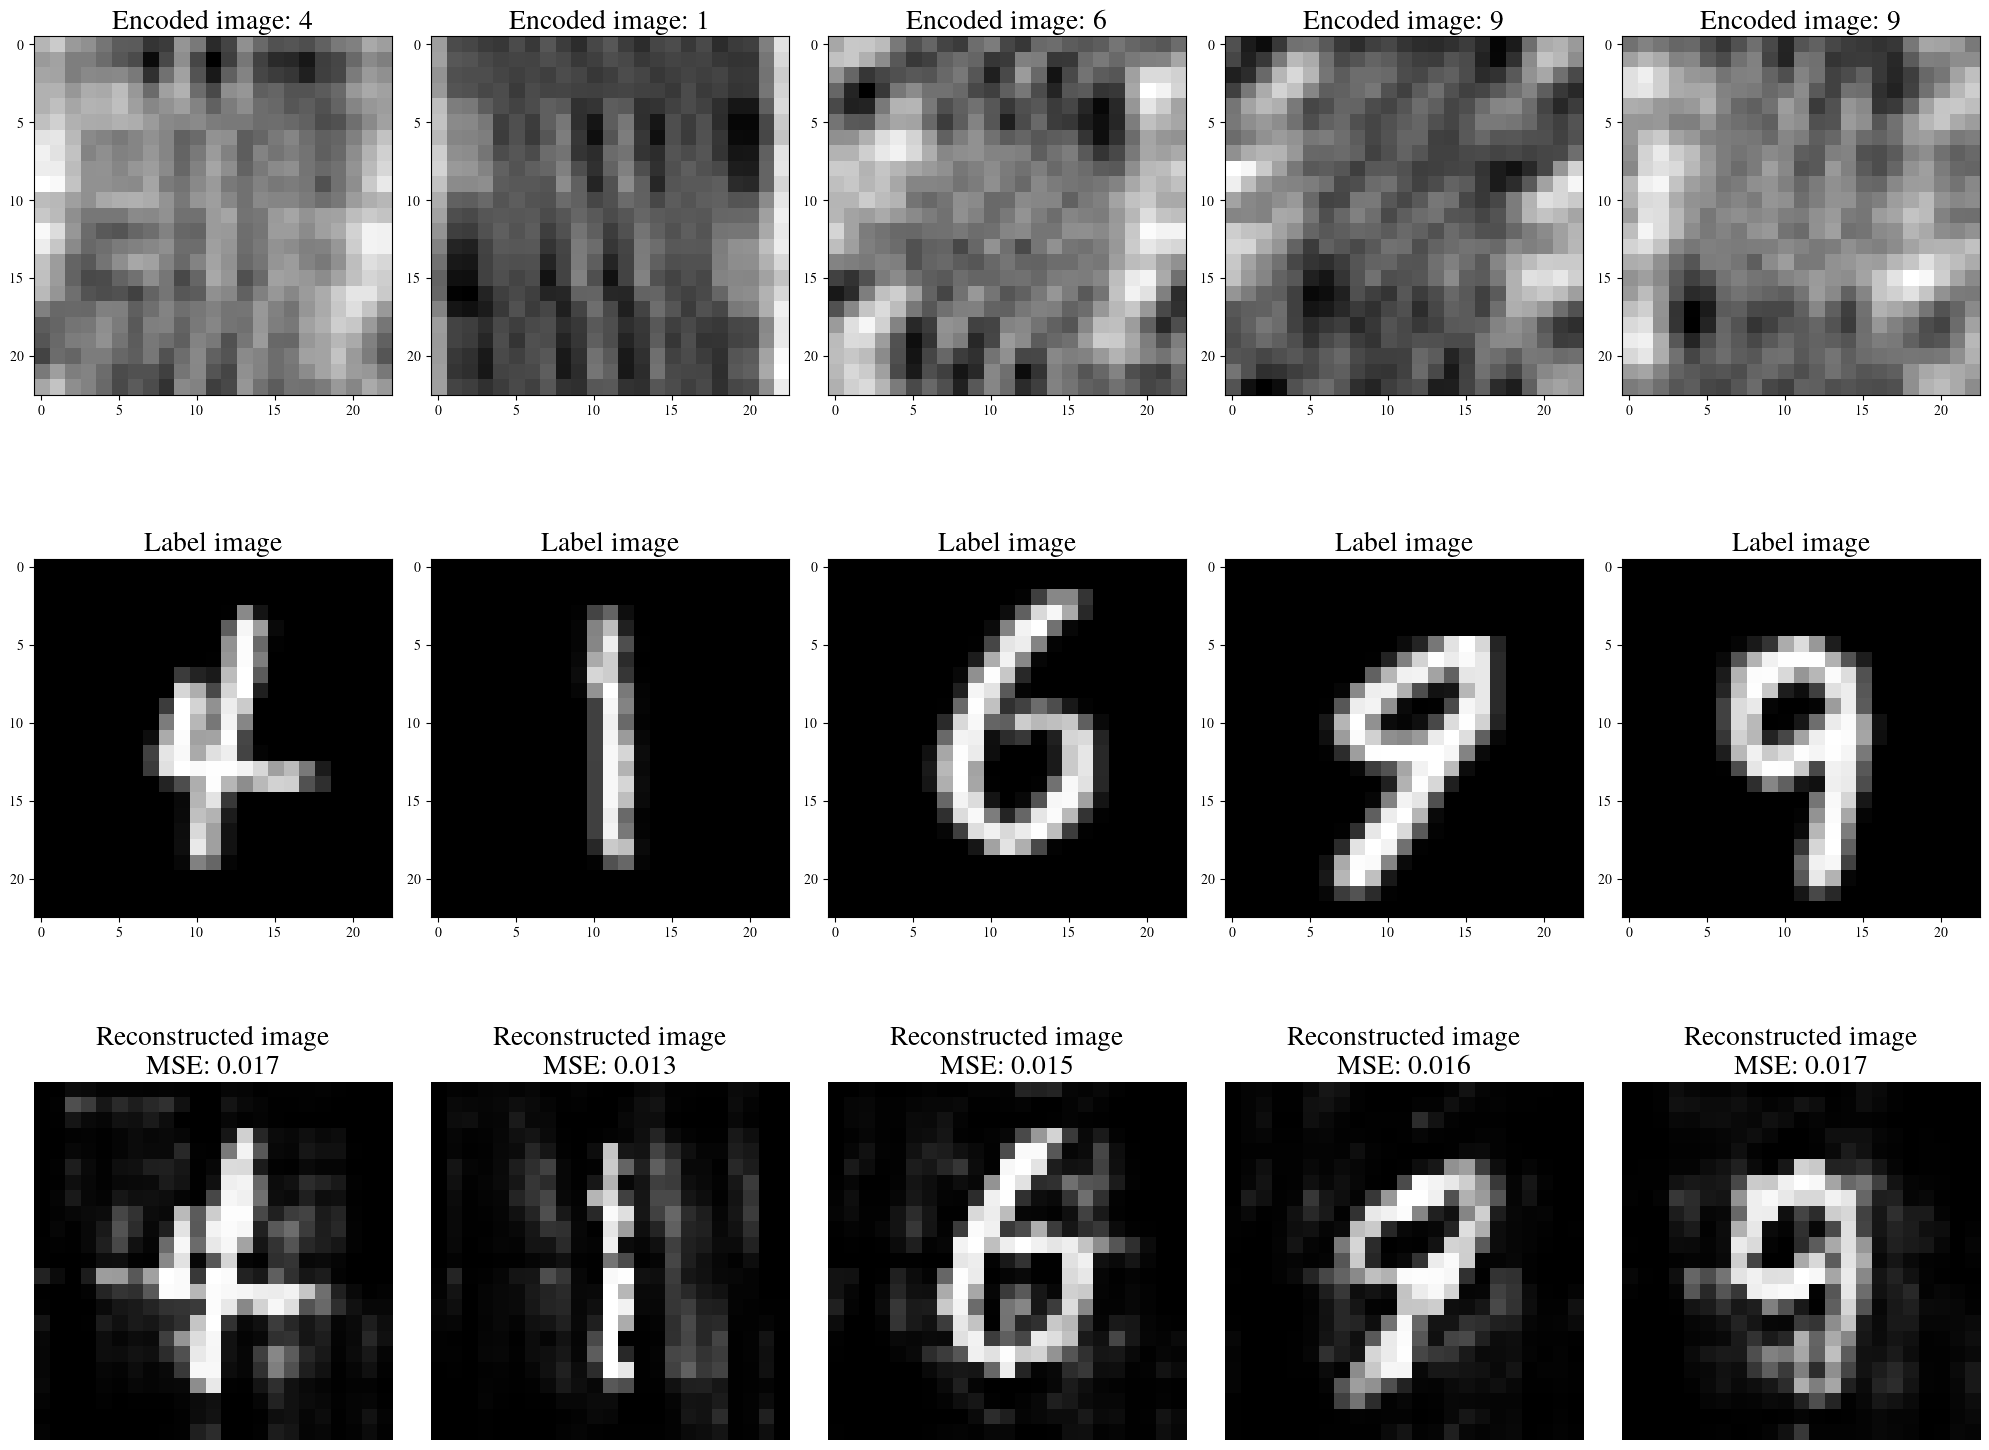

In [54]:
# Printing random images from the training dataset
#random_samples = np.random.randint(1, len(loaders['test']), (5))
seed = 10  
title_size = 20
label_size = 16

for plot_num,idx in enumerate(top_25per.sample(n=5, random_state=seed).index): # df[df.mse_score > 0.29].index
    # Plot encoded input image
    plt.subplot(3, 5, plot_num + 1)
    input_img = torch.reshape(test_outputs['img'][idx], (model.img_size,model.img_size))
    plt.imshow(input_img, cmap='gray')
    plt.title(f"Encoded image: {test_outputs['digit'][idx]}", fontsize=title_size)
    
    # Plot original label image
    plt.subplot(3, 5, plot_num + 6)
    label_image = torch.reshape(test_outputs['label'][idx], (model.img_size,model.img_size))
    plt.imshow(label_image, cmap='gray')
    plt.title('Label image', fontsize=title_size)
    
    # Plot reconstruction
    plt.subplot(3, 5, plot_num + 11)
    pred_image = torch.reshape(test_outputs['pred'][idx], (model.img_size,model.img_size))
    #pred_image = mura.normalize(pred_image.numpy())
    mse_recon = sklearn.metrics.mean_squared_error(label_image, pred_image)
    plt.imshow(pred_image, cmap='gray')
    plt.title(f'Reconstructed image \n MSE: {mse_recon: .3f}', fontsize=title_size)
    plt.axis('off')

plt.tight_layout()
#plt.suptitle("Worst 5 performing images", fontsize = title_size+4) #"Best 25\% Performing test images"
#plt.savefig(f'../figs/top25per_reconstructions_seed{seed}.png')
#plt.savefig(f'../figs/bottom25per_reconstructions_seed{seed}.png')
#plt.savefig(f'../figs/worst5_reconstructions.png')
plt.show()

In [67]:
#------------------------- Save the final weights --------------------------
final_weights = list(model.parameters())
print(final_weights[0].shape)
final_weight_map = final_weights[0].detach().cpu().numpy()
np.save(path+'metrics/final_weight_CNN_23kernel',final_weight_map)
print(final_weight_map.shape)

torch.Size([1, 1, 23, 23])
(1, 1, 23, 23)


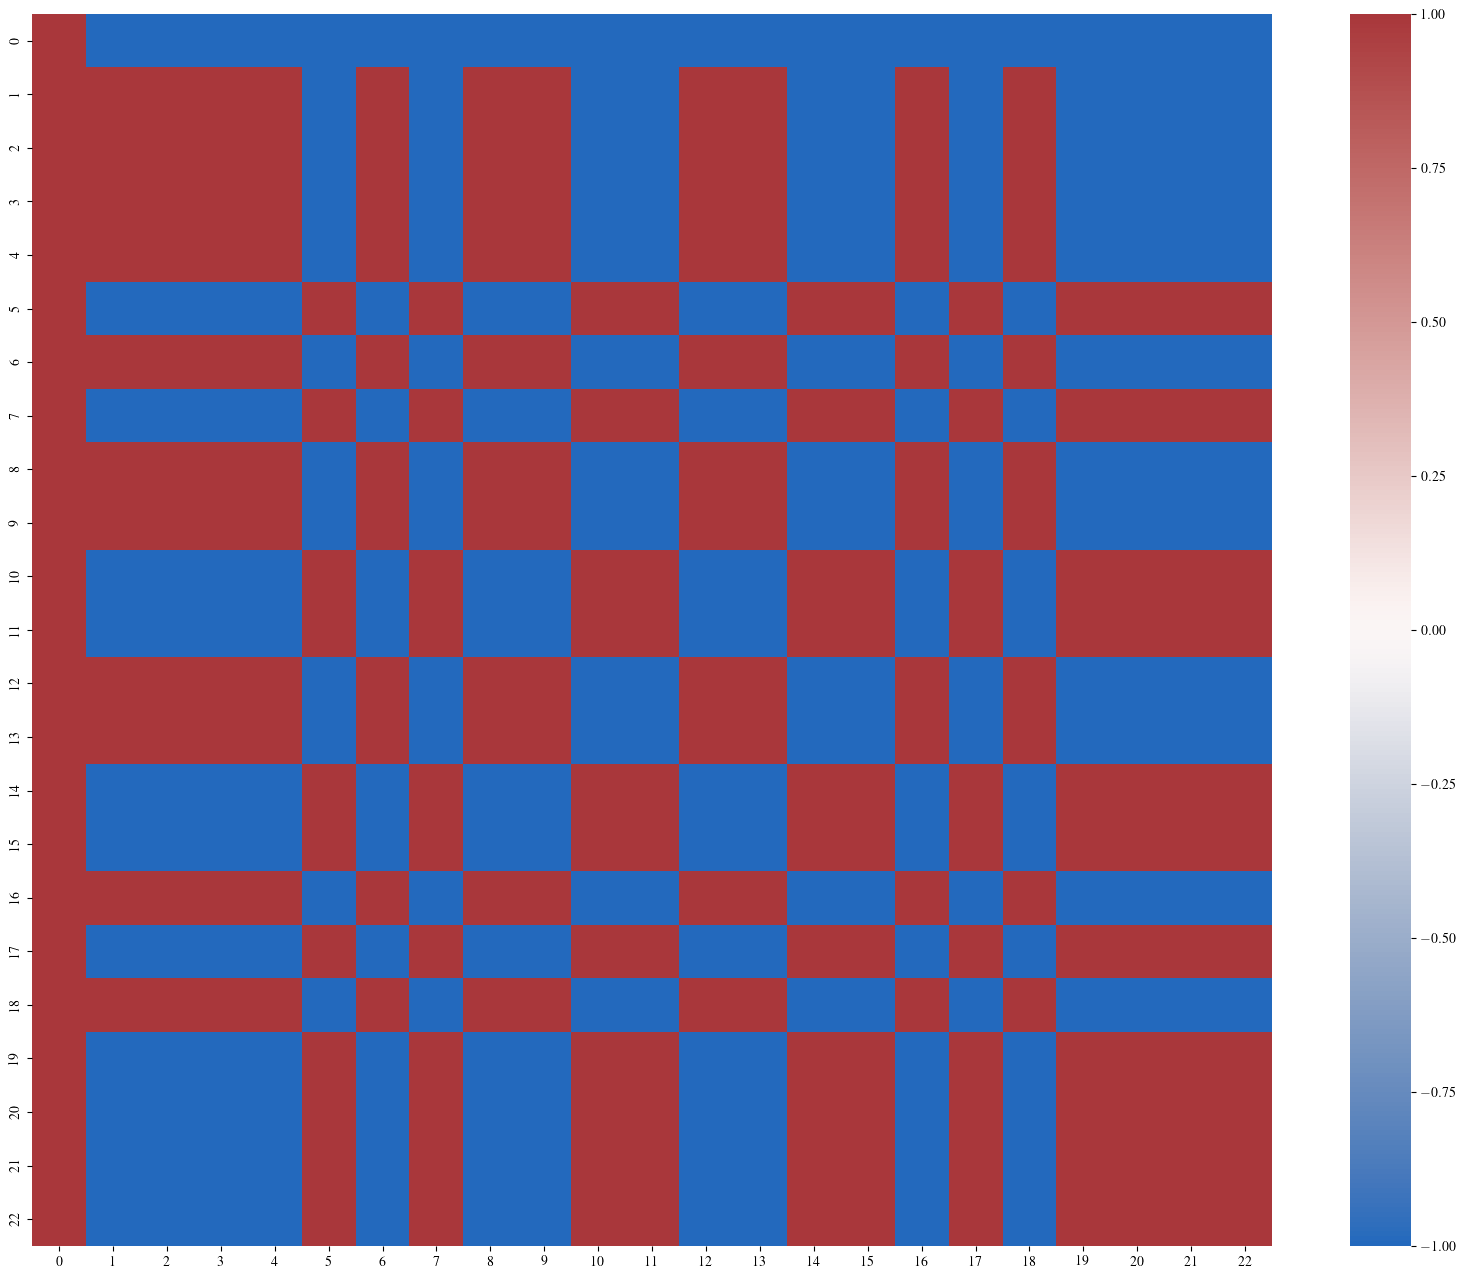

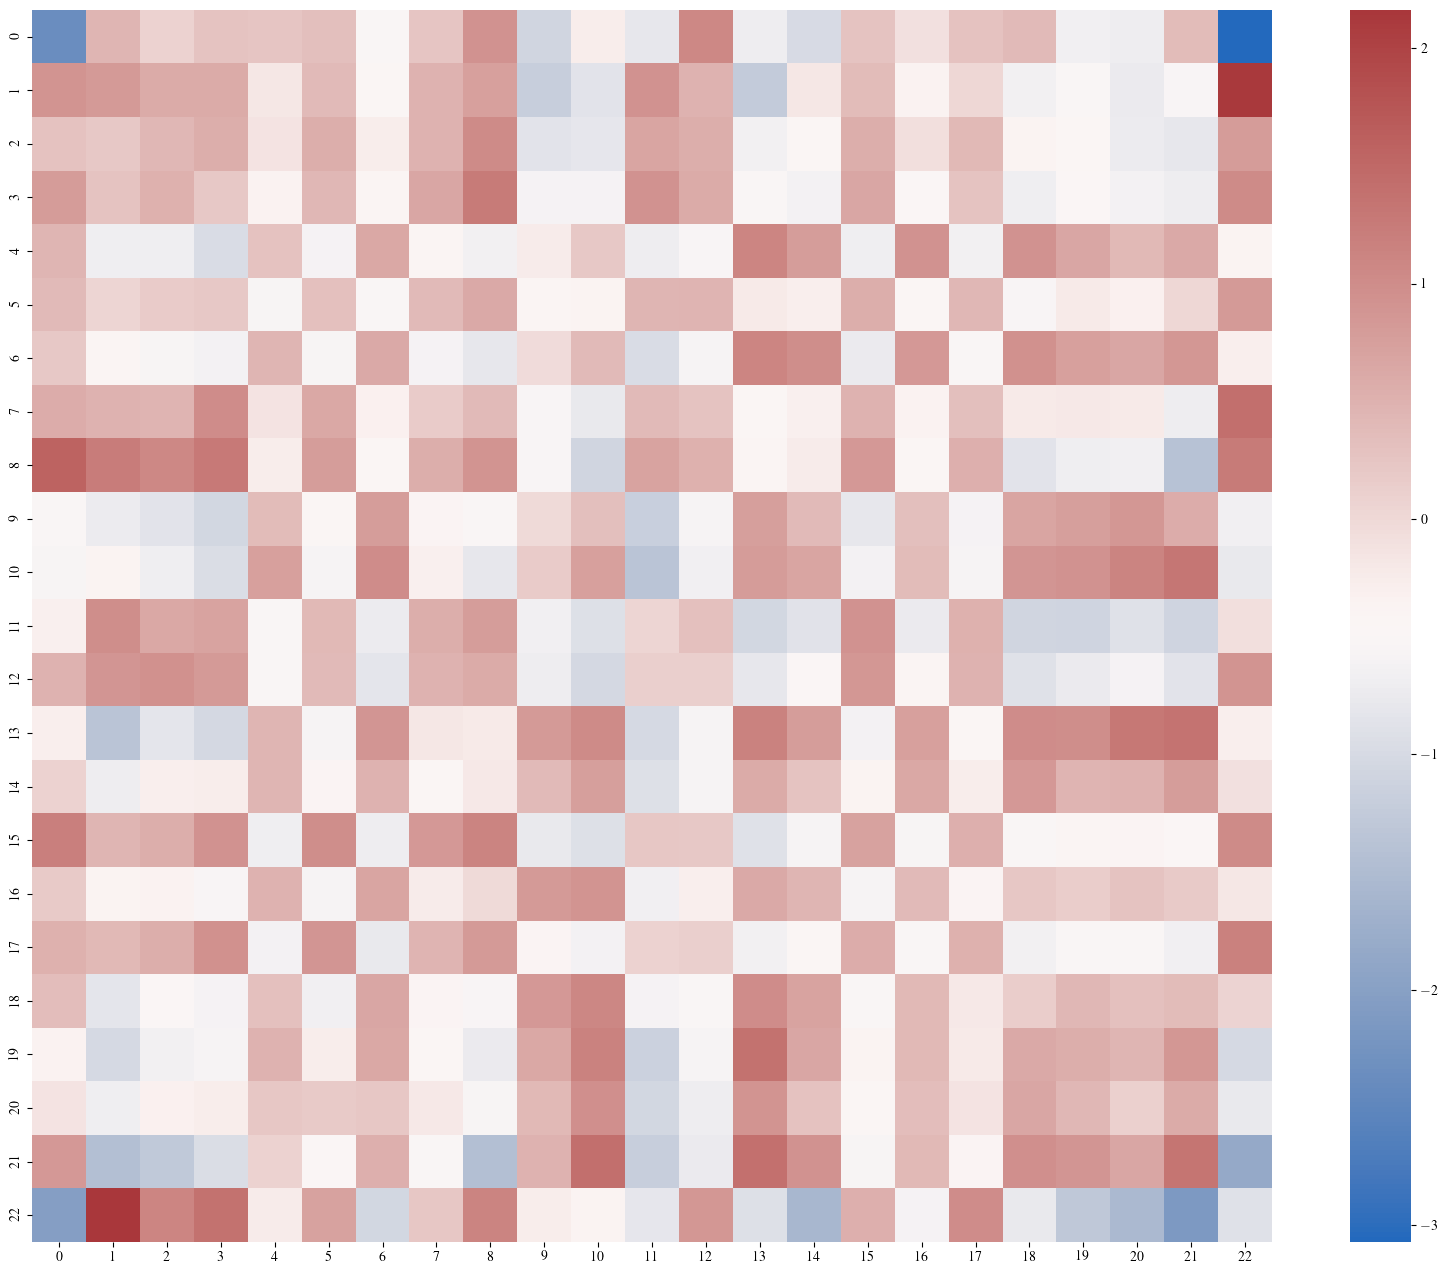

<AxesSubplot:>

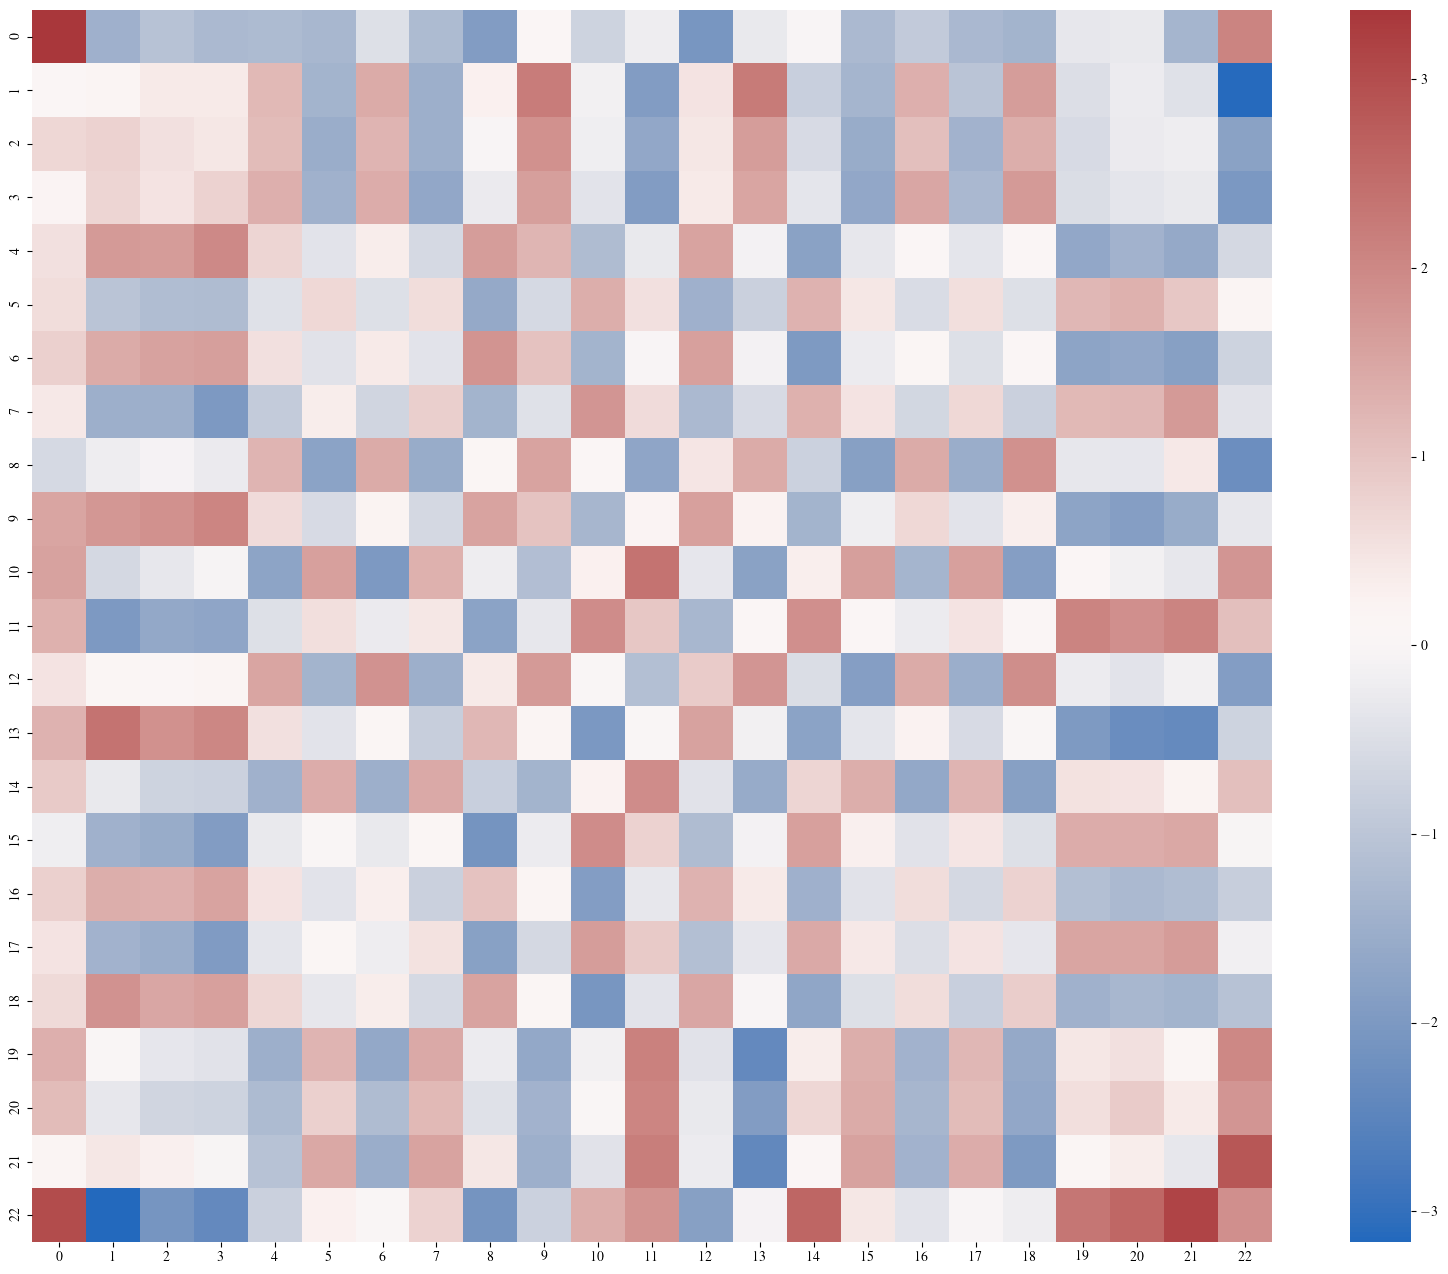

In [74]:
sns.heatmap(G, cmap='vlag')
plt.show()

sns.heatmap(np.squeeze(final_weight_map), cmap='vlag')
plt.show()

sns.heatmap(G - np.squeeze(final_weight_map), cmap='vlag')
plt.show()

In [ ]:
#-

final_weights = list(net.parameters())
print(final_weights[0].shape)
final_weight_map = final_weights[0].detach().cpu().numpy()
np.save(folder_name+'metrics/final_weight',final_weight_map)
print(final_weight_map.shape)
#print(weight_map)

plt.figure(figsize=(15,15))
heat = seaborn.heatmap(final_weight_map)
figure = heat.get_figure()
figure.savefig(folder_name+'/metrics/heat_final.png',bbox='tight', dpi=400)
plt.close()
# ==============================================================================

# To be deleted

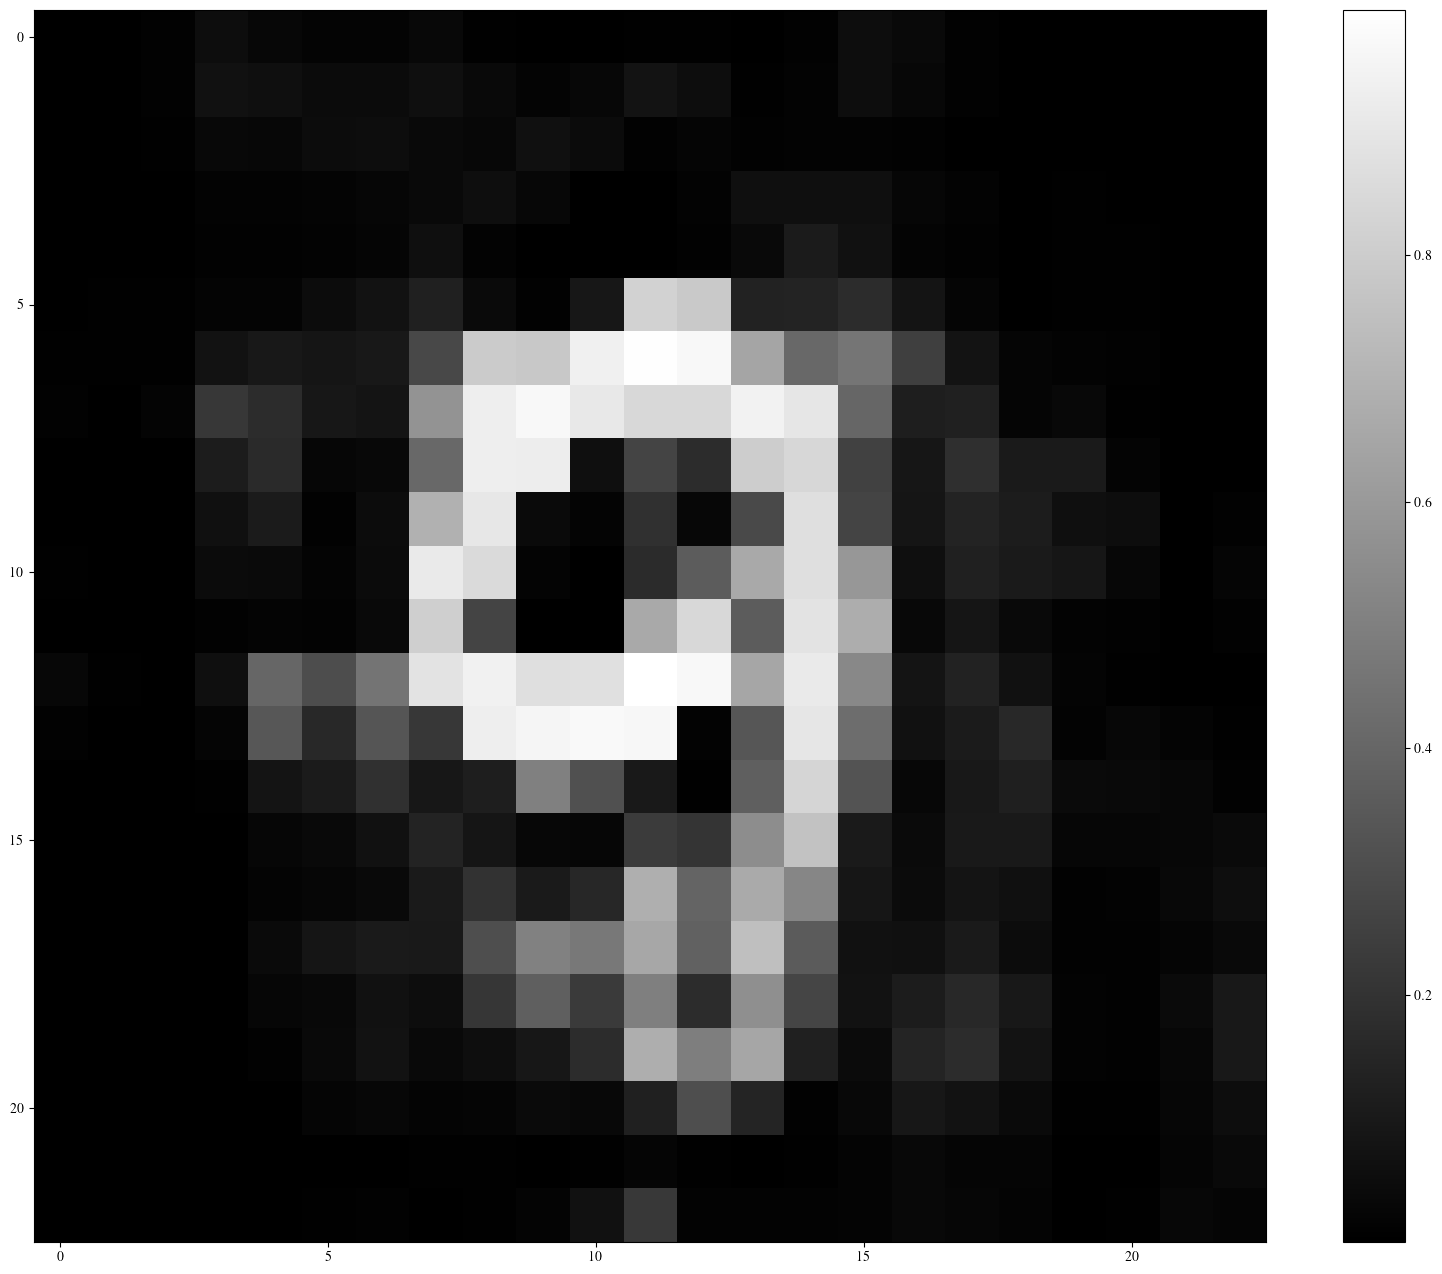

In [55]:
test = pred_image.numpy().copy()
test[np.where(test <=0)] = 0
plt.imshow(test, cmap='gray')
plt.colorbar()

In [81]:
cnn = CNN()
cnn.load_state_dict(torch.load('../models/mnist_50epochs.pth'))

<All keys matched successfully>

In [ ]:
torch.tensor((df.iloc[index].pred > 0.5).numpy().astype('float'))

In [82]:
df.pred.iloc[0].shape

torch.Size([1, 23, 23])

In [96]:
# Get one image from test set and reshape for model
#index = 1
cnn_pred = []
true_label = []

for index in top_25per.index: #range(len(df)):
    
    one_img = torch.reshape(df.pred.iloc[index],(1,1, model.img_size, model.img_size)) 

    # Input image batch into model to get predictions
    outputs = cnn(one_img)
    _, predicted = torch.max(outputs, 1)
    cnn_pred.append(predicted.numpy()[0])
    true_label.append(df.digit.iloc[index].numpy())
    #print(f"Model predicted {predicted.numpy()[0]}. True label is {df.digit.iloc[index].numpy()}")

In [31]:
from torchvision import models

In [32]:
resnet = models.resnet50(pretrained=True)

In [33]:
resnet.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(0,0), bias=False)
resnet.fc = torch.nn.Linear(2048, 10, bias=True)

In [34]:
# Get one image from test set and reshape for model
#index = 1
cnn_pred = []
true_label = []

for index in top_25per.index: #range(len(df)):
    
    one_img = torch.reshape(df.pred.iloc[index],(1,1, model.img_size, model.img_size)) 

    # Input image batch into model to get predictions
    outputs = resnet(one_img)
    _, predicted = torch.max(outputs, 1)
    cnn_pred.append(predicted.numpy()[0])
    true_label.append(df.digit.iloc[index].numpy())
    #print(f"Model predicted {predicted.numpy()[0]}. True label is {df.digit.iloc[index].numpy()}")

[E thread_pool.cpp:112] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:112] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:112] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

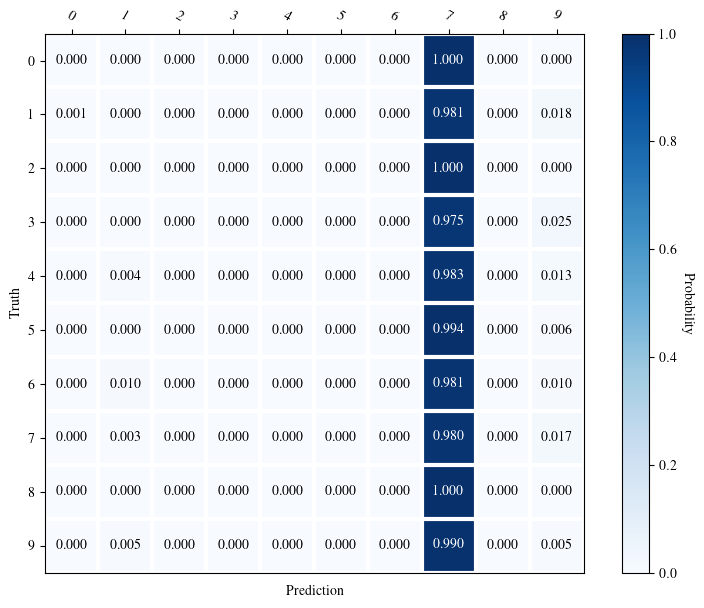

In [35]:
## Confusion Matrix
# Converting list of tensors to list of integers
preds = [pred for pred in cnn_pred]
truths = [tru for tru in true_label]

con_mat = sklearn.metrics.confusion_matrix(truths,preds,normalize='true')
axlabels= [ str(num) for num in np.arange(10)]

fig, ax = plt.subplots(figsize=(10,7))
im, cbar = cm.heatmap(con_mat, axlabels, axlabels, ax=ax,cmap = 'Blues', cbarlabel="Probability")
plt.ylabel("Truth")
plt.xlabel("Prediction")
texts = cm.annotate_heatmap(im, valfmt="{x:.3f}")
fig1 = plt.gcf()
#fig1.savefig("../figs/conf_mat.png")